In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import shutil
import nibabel as nib
import pydicom as dicomio 
import torch
import torch.optim as optim
import time

# 让 matplotlib 图表直接在 Jupyter 中显示
%matplotlib inline 

# 导入本地模块
try:
    from loss import TverskyLoss, MixedLoss
    from net import UNet_2D, UNet_3D
    from volume_patch_composer import volume_composer, patch_creator
    from dataset import Pancreas_2D_dataset, Pancreas_3D_dataset, partitioning
    from metrics import performance_metrics
    from train import train_2D, train_3D
    from inference import get_inference_performance_metrics_3D
except ImportError as e:
    print(f"❌ 错误: 缺少必要的模块文件 (如 net.py, loss.py)。\n详细信息: {e}")

print("库导入完成。")

库导入完成。


In [2]:
# ================= ⚙️ 配置区域 =================
CONFIG = {
    'raw_ct_dir': 'autodl-tmp/Pancreas-CT',              
    'raw_label_dir': 'autodl-tmp/Pancreas-CT-Label',     
    'processed_2d_dir': './data',               
    'processed_3d_dir': './data3D',             
    
    'unet_2d': False,              
    'batch_size': 4,                
    'num_workers': 20,               
    'n_epochs': 50,                
    'inference_only': False,       
    'train_on_gpu': torch.cuda.is_available(),
    'seed': 51
}

# ================= 🛠️ 工具函数 =================
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

def process_ct_window(ct_array, w_level=40, w_width=400):
    # 步骤 1：计算窗的上下界
    min_val = w_level - w_width / 2
    max_val = w_level + w_width / 2
    # 步骤 2：截断 (Clipping)
    ct_clipped = np.clip(ct_array, min_val, max_val)
    # 步骤 3：归一化到 [0, 1]
    ct_norm = (ct_clipped - min_val) / (max_val - min_val)
    # 步骤 4：扩展到 [0, 255] 并转为整数
    ct_norm = ct_norm * 255.0
    return ct_norm.astype(np.uint8)

def prepare_directories():
    for p in [CONFIG['processed_2d_dir'], CONFIG['processed_3d_dir']]:
        if not os.path.exists(p):
            os.makedirs(p)

# 设置随机种子
set_seed(CONFIG['seed'])
print("配置已加载。")

配置已加载。


In [3]:
def preprocess_data_robust():
    """鲁棒的数据预处理函数"""
    print("--- 检查数据状态 ---")
    check_patient = os.path.join(CONFIG['processed_2d_dir'], 'Patient0082', 'CT')
    if os.path.exists(check_patient) and len(os.listdir(check_patient)) > 0:
        print("✅ 检测到本地已有预处理数据 (./data)，跳过 PNG 生成步骤。")
        return

    print("🔄 未找到完整数据，开始执行预处理 (这可能需要几分钟)...")
    prepare_directories()

    # 检查 pydicom 版本兼容性
    try:
        if not hasattr(dicomio, 'dcmread'):
            dicomio.dcmread = dicomio.read_file
    except:
        pass

    for i in range(1, 83):
        patient_id = '{:04d}'.format(i)
        
        # 路径准备
        nifti_filename = f"label{patient_id}.nii.gz"
        nifti_path = os.path.join(CONFIG['raw_label_dir'], nifti_filename)
        ct_folder_pattern = os.path.join(CONFIG['raw_ct_dir'], f"PANCREAS_{patient_id}", "**", "*.dcm")
        
        # 1. 检查源文件
        if not os.path.exists(nifti_path):
            # print(f"⚠️  [Patient {patient_id}] 跳过: 找不到标签文件")
            continue
        
        dcm_files = glob.glob(ct_folder_pattern, recursive=True)
        if not dcm_files:
            # print(f"⚠️  [Patient {patient_id}] 跳过: 找不到 DICOM 文件")
            continue

        # 2. 读取并排序 DICOM
        try:
            slices = []
            for f in dcm_files:
                try:
                    ds = dicomio.dcmread(f)

                    # 先转为 float 避免计算溢出
                    image = ds.pixel_array.astype(np.float32)
                    
                    # 应用斜率和截距 (如果存在)
                    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
                        # print('应用斜率和截距')
                        slope = float(ds.RescaleSlope)
                        intercept = float(ds.RescaleIntercept)
                        image = image * slope + intercept

                    # slices.append(ds)
                    slices.append((float(ds.ImagePositionPatient[2]), image))
                except Exception:
                    pass
            
            if not slices:
                continue

            # 按 Z 轴位置排序
            # slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
            slices.sort(key=lambda x: x[0])
            
        except Exception as e:
            print(f"❌ [Patient {patient_id}] 处理崩溃: {e}")
            continue

        # 3. 读取 Mask
        try:
            mask_obj = nib.load(nifti_path)
            mask_data = mask_obj.get_fdata()
        except Exception as e:
            print(f"❌ [Patient {patient_id}] NIfTI 读取失败: {e}")
            continue

        # 4. 对齐层数
        num_dcm = len(slices)
        num_mask = mask_data.shape[2]
        valid_slices = min(num_dcm, num_mask)
        
        if valid_slices < 10:
            continue
            
        # 5. 保存 PNG
        save_dir_ct = os.path.join(CONFIG['processed_2d_dir'], 'Patient' + patient_id, 'CT')
        save_dir_mask = os.path.join(CONFIG['processed_2d_dir'], 'Patient' + patient_id, 'Masks')
        os.makedirs(save_dir_ct, exist_ok=True)
        os.makedirs(save_dir_mask, exist_ok=True)

        # ... (前面的代码保持不变)
        try:
            for s in range(valid_slices):
                # 获取掩码
                mask_slice = mask_data[:, :, s]
                
                # 获取原始 CT 数据，转置
                # raw_ct_slice = slices[s].pixel_array.transpose(1, 0)
                raw_ct_slice = slices[s][1].transpose(1, 0) 
                
                # --- 🔥 修改开始 🔥 ---
                # 1. 对 CT 进行窗位调整和归一化 (关键修复!)
                processed_ct_slice = process_ct_window(raw_ct_slice, w_level=40, w_width=400)
                
                # 2. 确保 Mask 也是 uint8 格式 (0 和 255, 或者 0 和 1)
                # 建议将 Mask 乘以 255 以便肉眼观察，但在读取时要除回来
                mask_slice = (mask_slice * 255).astype(np.uint8)
                # 这里为了兼容你现有的 dataset 代码(假设它读取0/1)，我们保持 0/1 但转为 uint8
                # mask_slice = mask_slice.astype(np.uint8)
                # --- 🔥 修改结束 🔥 ---

                # --- 🛠️ 验证代码开始 🛠️ ---
                # 仅检查前 3 个病人，且仅当 Mask 有内容时才验证，防止生成太多图片
                if int(patient_id) < 4 and mask_slice.sum() > 0:
                    import matplotlib.pyplot as plt
                    
                    # 创建一个临时验证文件夹
                    debug_dir = './debug_alignment'
                    os.makedirs(debug_dir, exist_ok=True)
                    
                    plt.figure(figsize=(10, 10))
                    # 显示 CT 底图 (灰度)
                    plt.imshow(processed_ct_slice, cmap='gray')
                    # 叠加 Mask (红色，半透明 alpha=0.5)
                    # np.ma.masked_where 用于隐藏 Mask 中为 0 的背景部分，只显示胰腺
                    masked_label = np.ma.masked_where(mask_slice == 0, mask_slice)
                    plt.imshow(masked_label, cmap='jet', alpha=0.5, interpolation='none')
                    
                    plt.title(f"Patient {patient_id} - Slice {s} - Alignment Check")
                    # 保存图片
                    plt.savefig(os.path.join(debug_dir, f"Check_P{patient_id}_S{s}.png"))
                    plt.close()
                    
                    # print(f"✅ 已保存验证图片到 {debug_dir}/Check_P{patient_id}_S{s}.png，请立即下载查看！")
                    # --- 🛠️ 验证代码结束 🛠️ ---

                filename = f"{s:04d}.png"
                cv2.imwrite(os.path.join(save_dir_mask, filename), mask_slice)
                cv2.imwrite(os.path.join(save_dir_ct, filename), processed_ct_slice)
            
        except Exception as e:
            print(f"❌ [Patient {patient_id}] 保存出错: {e}")      

    print("--- 数据预处理完成 ---")

In [ ]:
# 1. 执行预处理
preprocess_data_robust()

# 2. 构建数据索引
print("构建文件索引...")
patient_path_list = {'CT': {}, 'Masks': {}}
patient_image_cnt_CT = {}
patient_image_cnt_Mask = {}
valid_patients = []
patient_dirs = sorted(glob.glob(os.path.join(CONFIG['processed_2d_dir'], 'Patient*')))

for p_dir in patient_dirs:
    p_key = os.path.basename(p_dir)
    ct_files = sorted(glob.glob(os.path.join(p_dir, 'CT', '*.png')))
    mask_files = sorted(glob.glob(os.path.join(p_dir, 'Masks', '*.png')))
    if len(ct_files) > 0 and len(ct_files) == len(mask_files):
        patient_path_list['CT'][p_key] = ct_files
        patient_path_list['Masks'][p_key] = mask_files
        patient_image_cnt_CT[p_key] = len(ct_files)
        patient_image_cnt_Mask[p_key] = len(mask_files)
        valid_patients.append(p_key)

print(f"有效病例数: {len(valid_patients)}")

# 3. 3D 数据缓存
print("检查 3D 数据缓存...")
d1 = torch.linspace(-1, 1, 256)
d2 = torch.linspace(-1, 1, 256)
d3 = torch.linspace(-1, 1, 128)
meshx, meshy, meshz = torch.meshgrid((d1, d2, d3), indexing='ij') #将N个一维向量xyz扩展到 N 维空间中，三维空间每个点的xyz坐标值
grid = torch.stack((meshx, meshy, meshz), 3).unsqueeze(0) #增加批次（Batch）维度

new_pt_count = 0
for patient in valid_patients:
    out_ct_path = os.path.join(CONFIG['processed_3d_dir'], patient + '_CT.pt')
    if not os.path.exists(out_ct_path):
        try:
            volume_composer(patient, patient_image_cnt_CT, patient_path_list, grid)
            new_pt_count += 1
        except Exception as e:
            print(f"Resizing {patient} error: {e}")

if new_pt_count == 0:
    print("✅ 所有 3D 数据 (.pt) 已存在，跳过重采样步骤。")
else:
    print(f"🔄 新生成了 {new_pt_count} 个 3D 数据文件。")

--- 检查数据状态 ---
✅ 检测到本地已有预处理数据 (./data)，跳过 PNG 生成步骤。
构建文件索引...
有效病例数: 80
检查 3D 数据缓存...
✅ 所有 3D 数据 (.pt) 已存在，跳过重采样步骤。


In [5]:
# 4. 训练准备
print("准备 Dataset...")
part = partitioning(valid_patients, split_ratio=[0.7, 0.1, 0.2])

# 增加patch大小，可能需要调整学习率、数据增强尺寸、模型初始特征图数量
# 如果不能整除，PyTorch 的 unfold 操作默认会直接丢弃边缘无法凑够一个 Patch 的像素。
# kc, kh, kw = 32, 64, 64
# dc, dh, dw = 32, 64, 64
# kc, kh, kw = 48, 96, 96  
# dc, dh, dw = 48, 96, 96
kc, kh, kw = 128, 256, 256  
dc, dh, dw = 128, 256, 256


CT_patches = {}
mask_patches = {}

print("加载 Patches (这步需要一点内存)...")
for p in ['train', 'valid']:
    CT_patches[p], mask_patches[p] = patch_creator(part[p], kw, kh, kc, dw, dh, dc)

dataset_train = Pancreas_3D_dataset(CT_patches['train'], mask_patches['train'], augment=True, is_train=True)
dataset_valid = Pancreas_3D_dataset(CT_patches['valid'], mask_patches['valid'], augment=False, is_train=False)

loaders = {
    'train': torch.utils.data.DataLoader(dataset_train, batch_size=CONFIG['batch_size'], 
                                         shuffle=True, num_workers=CONFIG['num_workers'],pin_memory=True),# 启用内存锁定，加速数据传输
    'valid': torch.utils.data.DataLoader(dataset_valid, batch_size=CONFIG['batch_size'], 
                                         shuffle=False, num_workers=CONFIG['num_workers'],pin_memory=True)
}
print("DataLoader 准备就绪。")

准备 Dataset...
train:  56   valid:  7   test:  17   total:  80
加载 Patches (这步需要一点内存)...
Filtering patches... Original size: 56
Filtered size: 56
DataLoader 准备就绪。


--- 🔍 正在检查 DataLoader 输出 ---
📦 Batch Shape: Images=torch.Size([4, 1, 128, 256, 256]), Targets=torch.Size([4, 1, 128, 256, 256])
📊 Image Values: min=0.0000, max=1.0000, mean=0.1425
🎯 Target Values: min=0.0000, max=1.0000
🔢 Target Unique Values (前10个): tensor([0, 1], dtype=torch.int32)


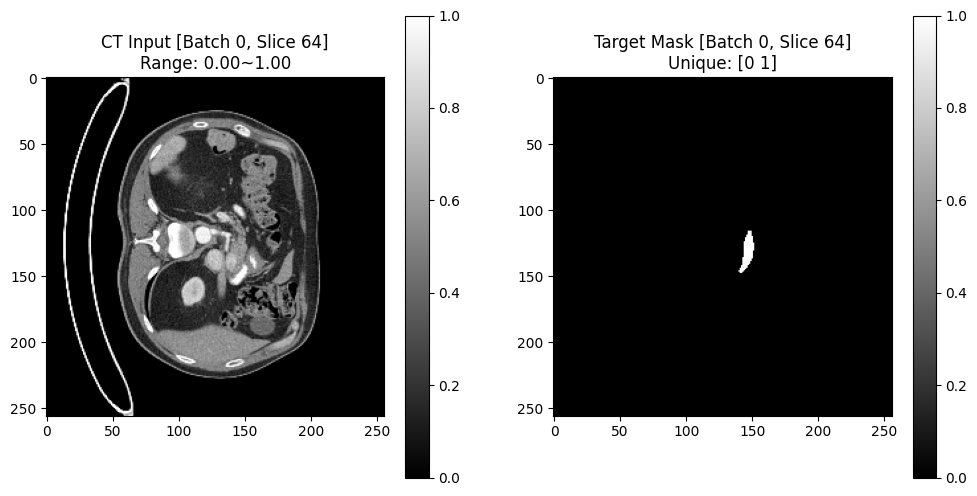

✅ 数据范围看起来正常。请检查上图：CT是否清晰？Mask是否有白色高亮区域？


In [6]:
import matplotlib.pyplot as plt
import torch
import numpy as np

print("--- 🔍 正在检查 DataLoader 输出 ---")

# 1. 从训练集 Loader 中取出一个 Batch
# iter() 创建迭代器，next() 获取第一组数据
try:
    data_iter = iter(loaders['train'])
    images, targets = next(data_iter)
except Exception as e:
    print(f"❌ DataLoader 读取失败: {e}")
    # 如果失败，可能是 num_workers 太大导致多进程报错，尝试设为 0 调试
    print("尝试将 CONFIG['num_workers'] 设为 0 再试。")
    raise e

# 2. 打印基础统计信息
print(f"📦 Batch Shape: Images={images.shape}, Targets={targets.shape}")
print(f"📊 Image Values: min={images.min():.4f}, max={images.max():.4f}, mean={images.mean():.4f}")
print(f"🎯 Target Values: min={targets.min():.4f}, max={targets.max():.4f}")
print(f"🔢 Target Unique Values (前10个): {torch.unique(targets)[:10]}")

# 3. 可视化检查 (取 Batch 中的第 0 个样本)
idx = 0 
# 获取 3D 数据的中间切片索引 (Depth / 2)
mid_slice = images.shape[2] // 2 

img_slice = images[idx, 0, mid_slice, :, :].numpy()
mask_slice = targets[idx, 0, mid_slice, :, :].numpy()

plt.figure(figsize=(12, 6))

# 左图：CT 原图
plt.subplot(1, 2, 1)
plt.imshow(img_slice, cmap='gray')
plt.title(f"CT Input [Batch {idx}, Slice {mid_slice}]\nRange: {img_slice.min():.2f}~{img_slice.max():.2f}")
plt.colorbar()

# 右图：Mask 标签
plt.subplot(1, 2, 2)
plt.imshow(mask_slice, cmap='gray')
plt.title(f"Target Mask [Batch {idx}, Slice {mid_slice}]\nUnique: {np.unique(mask_slice)}")
plt.colorbar()

plt.show()

# 4. 关键逻辑判断
if targets.max() > 1.0:
    print("❌ 严重警告: Mask 值大于 1.0 (例如 255)！这会导致 Dice Loss 失效。")
    print("👉 请检查 volume_patch_composer 或 Dataset 中的归一化除法。")
elif targets.sum() == 0:
    print("⚠️ 警告: 这个 Batch 里似乎全是背景 (Mask 全黑)。")
    print("👉 如果这种情况频繁出现，说明你的采样策略 (15% 背景保留) 可能没生效，或者 Patch 太小切不到胰腺。")
else:
    print("✅ 数据范围看起来正常。请检查上图：CT是否清晰？Mask是否有白色高亮区域？")

In [7]:
# 5. 初始化模型与优化器
print("初始化模型...")
model = UNet_3D(1, 1, 32, 0.3)

# ================= 关键修改：加载预训练模型 =================
# ⚠️ 注意：请确认文件名是否正确
checkpoint_path = 'results/run_20251130-0316_model.pt' 

if os.path.exists(checkpoint_path):
    print(f"🔄 正在加载预训练模型: {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path))
    print("✅ 加载成功！将在现有基础上继续训练。")
else:
    print("⚠️ 未找到预训练模型，将从头开始训练。")     
# ========================================================

if CONFIG['train_on_gpu']:
    # 1. 先把模型搬到主 GPU (cuda:0)
    model.cuda()
    
    # 2. 再进行多卡包装
    if torch.cuda.device_count() > 1:
        print(f"🚀 检测到 {torch.cuda.device_count()} 个 GPU，已启用多卡并行训练 (DataParallel)!")
        # 使用 DataParallel 包装模型
        model = torch.nn.DataParallel(model)       

# ✅ 使用新的混合 Loss
# alpha=0.7 强调召回，bce_weight=0.5 提供梯度平滑
criterion = MixedLoss(alpha=0.7, beta=0.3, bce_weight=1.0, pos_weight=10)
if CONFIG['train_on_gpu']:
        criterion.cuda()

# 纯 BCE：估算一个权重，比如前景只占 5%，那么权重设为 20 左右；
# 对于胰腺分割，通常设 10.0 到 50.0 之间。你可以先试 10.0。
# 如果 train_on_gpu 为 True，必须把权重也移到 GPU
# pos_weight = torch.tensor([15.0])
# if torch.cuda.is_available():
#     pos_weight = pos_weight.cuda()
# criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# 定义 Loss (这里用了你新的参数)
# criterion = TverskyLoss(1e-6, 0.7, 0.3)

# 1. 定义基础优化器 (LR 会被 Scheduler 覆盖，所以这里初始 LR 可以随意，但建议设为 max_lr 的 1/10 或 1/25)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # 在优化器中增加权重衰减
# 推荐使用 AdamW
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)

# 2.定义 OneCycleLR
# max_lr: 最大学习率，可以尝试 1e-3 或 5e-4
# steps_per_epoch: 每个 epoch 的 batch 数量
# epochs: 总 epoch 数
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=5e-4, 
    steps_per_epoch=len(loaders['train']), 
    epochs=CONFIG['n_epochs']
)

# 余弦退火热身重启
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer, 
#     T_0=20,           # 初始周期长度
#     T_mult=2,         # 周期倍增因子
#     eta_min=1e-6
# )

#当指标进入平原期（不再变化）时，降低学习率。
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min',      # 监控指标是越小越好 (Loss)
#     factor=0.5,      # 每次降低一半 (0.1 也可以)
#     patience=10,     # 容忍 10 个 Epoch 不下降
# )

print("模型初始化完成。")

初始化模型...
🔄 正在加载预训练模型: results/run_20251130-0316_model.pt
✅ 加载成功！将在现有基础上继续训练。
🚀 检测到 4 个 GPU，已启用多卡并行训练 (DataParallel)!
模型初始化完成。


In [ ]:
# 设置保存路径
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
timestamp = time.strftime("%Y%m%d-%H%M")
experiment_name = f"run_{timestamp}"
model_save_path = os.path.join(results_dir, f"{experiment_name}_model.pt")
loss_plot_path = os.path.join(results_dir, f"{experiment_name}_loss_curve.png")
metric_save_path = os.path.join(results_dir, f"{experiment_name}_metrics.csv")
test_save_path = os.path.join(results_dir, f"{experiment_name}_inference_results.csv")

print(f"🚀 开始训练: {experiment_name}")

if not CONFIG['inference_only']:
    # 3. 把 scheduler 传进去
    model = train_3D(CONFIG['n_epochs'], loaders, model, optimizer, criterion, 
                     CONFIG['train_on_gpu'], performance_metrics, model_save_path,metric_save_path, 0.5, 
                     scheduler=scheduler) # 传入 scheduler
    
    # 训练结束后处理数据
    if os.path.exists(metric_save_path):
        df = pd.read_csv(metric_save_path)
        
        # 直接在 Jupyter 中画图
        plt.figure(figsize=(10, 5))
        plt.plot(df['epoch'], df['Training Loss'], label='Train')
        plt.plot(df['epoch'], df['Validation Loss'], label='Valid')
        plt.legend()
        plt.title(f'Training Process ({experiment_name})')
        
        plt.savefig(loss_plot_path)
        plt.show() # 保存后再显示        
        
        print("训练完成。")

🚀 开始训练: run_20251201-0237


  0%|          | 0/51 [00:00<?, ?it/s]

=== Epoch #1 ===
=== Training ===

DEBUG: Data Shape: torch.Size([4, 1, 128, 256, 256])
DEBUG: Target Shape: torch.Size([4, 1, 128, 256, 256])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 14...
=== Validation ===
1 / 2...


  2%|▏         | 1/51 [01:27<1:13:16, 87.94s/it]

Epoch: 1 	Training Loss: 0.9895 	Validation Loss: 0.9515 	LR: 0.000025
Specificity: 0.995872 	Sensitivity: 0.369173 	Precision: 0.140740 	F2_score: 0.278695 	DSC: 0.203785
Validation DSC increased.  Saving model ...
=== Epoch #2 ===
=== Training ===

DEBUG: Data Shape: torch.Size([4, 1, 128, 256, 256])
DEBUG: Target Shape: torch.Size([4, 1, 128, 256, 256])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 14...
=== Validation ===
1 / 2...
Epoch: 2 	Training Loss: 0.9031 	Validation Loss: 0.9182 	LR: 0.000041
Specificity: 0.994055 	Sensitivity: 0.528650 	Precision: 0.138790 	F2_score: 0.338195 	DSC: 0.219734
Validation DSC increased.  Saving model ...


  4%|▍         | 2/51 [02:33<1:01:13, 74.97s/it]

=== Epoch #3 ===
=== Training ===

DEBUG: Data Shape: torch.Size([4, 1, 128, 256, 256])
DEBUG: Target Shape: torch.Size([4, 1, 128, 256, 256])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 14...
=== Validation ===
1 / 2...
Epoch: 3 	Training Loss: 0.8732 	Validation Loss: 0.8728 	LR: 0.000066
Specificity: 0.992770 	Sensitivity: 0.633887 	Precision: 0.137084 	F2_score: 0.367008 	DSC: 0.225239
Validation DSC increased.  Saving model ...


  6%|▌         | 3/51 [03:38<56:15, 70.32s/it]  

=== Epoch #4 ===
=== Training ===

DEBUG: Data Shape: torch.Size([4, 1, 128, 256, 256])
DEBUG: Target Shape: torch.Size([4, 1, 128, 256, 256])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 14...
=== Validation ===
1 / 2...
Epoch: 4 	Training Loss: 0.8165 	Validation Loss: 0.7860 	LR: 0.000100
Specificity: 0.994600 	Sensitivity: 0.584270 	Precision: 0.164976 	F2_score: 0.387313 	DSC: 0.257275
Validation DSC increased.  Saving model ...


  8%|▊         | 4/51 [04:45<53:56, 68.86s/it]

=== Epoch #5 ===
=== Training ===

DEBUG: Data Shape: torch.Size([4, 1, 128, 256, 256])
DEBUG: Target Shape: torch.Size([4, 1, 128, 256, 256])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 14...
=== Validation ===
1 / 2...
Epoch: 5 	Training Loss: 0.7969 	Validation Loss: 0.7630 	LR: 0.000141
Specificity: 0.996800 	Sensitivity: 0.489521 	Precision: 0.219916 	F2_score: 0.393094 	DSC: 0.303464
Validation DSC increased.  Saving model ...


 10%|▉         | 5/51 [05:51<52:01, 67.86s/it]

=== Epoch #6 ===
=== Training ===

DEBUG: Data Shape: torch.Size([4, 1, 128, 256, 256])
DEBUG: Target Shape: torch.Size([4, 1, 128, 256, 256])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 14...
=== Validation ===
1 / 2...
Epoch: 6 	Training Loss: 0.7508 	Validation Loss: 0.7376 	LR: 0.000187
Specificity: 0.996754 	Sensitivity: 0.507722 	Precision: 0.222146 	F2_score: 0.403814 	DSC: 0.309018
Validation DSC increased.  Saving model ...


 12%|█▏        | 6/51 [06:57<50:35, 67.45s/it]

=== Epoch #7 ===
=== Training ===

DEBUG: Data Shape: torch.Size([4, 1, 128, 256, 256])
DEBUG: Target Shape: torch.Size([4, 1, 128, 256, 256])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 14...
=== Validation ===
1 / 2...


 14%|█▎        | 7/51 [08:04<49:21, 67.30s/it]

Epoch: 7 	Training Loss: 0.7161 	Validation Loss: 0.7423 	LR: 0.000237
Specificity: 0.997654 	Sensitivity: 0.423146 	Precision: 0.247244 	F2_score: 0.370282 	DSC: 0.311974
Validation DSC increased.  Saving model ...
=== Epoch #8 ===
=== Training ===

DEBUG: Data Shape: torch.Size([4, 1, 128, 256, 256])
DEBUG: Target Shape: torch.Size([4, 1, 128, 256, 256])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 14...
=== Validation ===
1 / 2...
Epoch: 8 	Training Loss: 0.7122 	Validation Loss: 0.7033 	LR: 0.000287
Specificity: 0.996646 	Sensitivity: 0.532545 	Precision: 0.222846 	F2_score: 0.415912 	DSC: 0.313672
Validation DSC increased.  Saving model ...


 16%|█▌        | 8/51 [09:10<47:47, 66.68s/it]

=== Epoch #9 ===
=== Training ===

DEBUG: Data Shape: torch.Size([4, 1, 128, 256, 256])
DEBUG: Target Shape: torch.Size([4, 1, 128, 256, 256])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 14...
=== Validation ===
1 / 2...
Epoch: 9 	Training Loss: 0.6938 	Validation Loss: 0.6889 	LR: 0.000336
Specificity: 0.998299 	Sensitivity: 0.428089 	Precision: 0.314014 	F2_score: 0.398906 	DSC: 0.362067
Validation DSC increased.  Saving model ...


 18%|█▊        | 9/51 [10:16<46:36, 66.59s/it]

=== Epoch #10 ===
=== Training ===

DEBUG: Data Shape: torch.Size([4, 1, 128, 256, 256])
DEBUG: Target Shape: torch.Size([4, 1, 128, 256, 256])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 14...
=== Validation ===
1 / 2...


 20%|█▉        | 10/51 [11:23<45:35, 66.71s/it]

Epoch: 10 	Training Loss: 0.6422 	Validation Loss: 0.7866 	LR: 0.000382
Specificity: 0.998806 	Sensitivity: 0.303560 	Precision: 0.316406 	F2_score: 0.305905 	DSC: 0.309624
=== Epoch #11 ===
=== Training ===

DEBUG: Data Shape: torch.Size([4, 1, 128, 256, 256])
DEBUG: Target Shape: torch.Size([4, 1, 128, 256, 256])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 14...


In [ ]:
print("\n--- 开始测试集评估 ---")
# 加载刚刚训练好的模型（或者你可以手动指定其他路径）
best_model_path = model_save_path
# best_model_path = 'results/run_20251129-1415_model.pt'

if os.path.exists(best_model_path):
    print(f"加载模型权重: {best_model_path}...")
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    
    print(f"正在测试 {len(part['test'])} 个测试集病例...")
    df_test = get_inference_performance_metrics_3D(model, part['test'], Pancreas_3D_dataset, 
                                                  CONFIG['batch_size'], CONFIG['train_on_gpu'], 
                                                  0.5, kw, kh, kc, dw, dh, dc)
    print("\n📊 测试集结果统计:")
    display(df_test.describe()) # Jupyter 特有的漂亮表格显示
    
    df_test.to_csv(test_save_path, index=False)
    print(f"✅ 详细测试结果已保存至: {test_save_path}")
    # 添加统计信息到同一个文件（追加模式）
    with open(test_save_path, 'a') as f:
        f.write('\n')  # 空行分隔
        f.write('# Statistical Summary\n')
        df_test.describe().to_csv(f, header=True)
else:
    print("未找到模型文件。")

In [ ]:
from inference import visualize_patient_prediction_3D

i=4
visualize_patient_prediction_3D(
    model=model, 
    patient=part['train'][i], # 可视化测试
    Pancreas_3D_dataset=Pancreas_3D_dataset, 
    batch_size=1, 
    train_on_gpu=CONFIG['train_on_gpu'],
    threshold=0.5, 
    kw=kw, kh=kh, kc=kc, dw=dw, dh=dh, dc=dc
)
visualize_patient_prediction_3D(
    model=model, 
    patient=part['valid'][i], # 可视化测试
    Pancreas_3D_dataset=Pancreas_3D_dataset, 
    batch_size=1, 
    train_on_gpu=CONFIG['train_on_gpu'],
    threshold=0.5, 
    kw=kw, kh=kh, kc=kc, dw=dw, dh=dh, dc=dc
)
visualize_patient_prediction_3D(
    model=model, 
    patient=part['test'][i], # 可视化测试
    Pancreas_3D_dataset=Pancreas_3D_dataset, 
    batch_size=1, 
    train_on_gpu=CONFIG['train_on_gpu'],
    threshold=0.5, 
    kw=kw, kh=kh, kc=kc, dw=dw, dh=dh, dc=dc
)

In [ ]:
# 训练结束后自动关机
# !shutdown